# 1. Evaluating and Improving Models

Training a deep learning model is an art, and to make sure our model is trained correctly, we need to keep track of certain metrics during training, such as the loss or the accuracy. We will learn how to calculate such metrics and how to reduce overfitting. 

## 1.1 Import Libraries

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchmetrics
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1.2 User Variables

In [38]:
face_mask_pkl = pd.read_pickle("../datasets/masks_dataset.pickle")

# 2. Exercises

## 2.1 Fine-tuning process

### Desscription

You are training a model on a new dataset and you think you can use a fine-tuning approach instead of training from scratch (i.e., training from randomly initialized weights).

To fine-tune a model on a new task, you need to follow a certain number of steps that are listed here.

### Instructions

* Order the sentences to follow the fine-tuning process.

### Answer

1. Find a model trained on a similar task
2. Load pre-trained weights
3. Freeze (or not) some of the layers in the model
4. Train with a smaller learning rate
5. Look at the loss values and see if the learning rate needs to be adjusted

## 2.2 Freeze layers of a model

### Description

You are about to fine-tune a model on a new task after loading pre-trained weights. The model contains three linear layers. However, because your dataset is small, you only want to train the last linear layer of this model and freeze the first two linear layers.

The model has already been created and exists under the variable ``model``. You will be using the ``named_parameters`` method of the model to list the parameters of the model. Each parameter is described by a name. This name is a string with the following naming convention: ``x.name`` where ``x`` is the index of the layer.

Remember that a linear layer has two parameters: the ``weight`` and the ``bias``.

### Instructions

* Use an ``if`` statement to check if a parameter is a weight from the first or second layer.
* Freeze the weights of the first two layers of this model.

In [4]:
model =nn.Sequential(
    nn.Linear(8, 16),
    nn.Linear(16, 32),
    nn.Linear(32, 10)
)

In [5]:
model.named_parameters()

<generator object Module.named_parameters at 0x00000227B4B21C40>

In [6]:
for name, param in model.named_parameters():
  
    # Check for first layer's weight
    if name == '0.weight':
   
        # Freeze this weight
         param.requires_grad = False
        
    # Check for second layer's weight
    if name == '1.weight':
      
        # Freeze this weight
        param.requires_grad = False

## 2.3 Layer initialization

### Description

The initialization of the weights of a neural network has been the focus of researchers for many years. When training a network, the method used to initialize the weights has a direct impact on the final performance of the network.

As a machine learning practitioner, you should be able to experiment with different initialization strategies. In this exercise, you are creating a small neural network made of two layers and you are deciding to initialize each layer's weights with the uniform method.

### Instructions

* For each layer (``layer0`` and ``layer1``), use the uniform initialization method to initialize the weights.

In [7]:
layer0 = nn.Linear(16, 32)
layer1 = nn.Linear(32, 64)

# Use uniform initialization for layer0 and layer1 weights
nn.init.uniform_(layer0.weight)
nn.init.uniform_(layer1.weight)

model = nn.Sequential(layer0, layer1)

## 2.4 Writing the evaluation loop

### Description

In this exercise, you will write an evaluation loop to compute validation loss. The evaluation loop follows a similar structure to the training loop but without gradient calculations or weight updates.

``model``, ``validationloader``, and loss function ``criterion`` have already been defined to handle predictions, data loading, and loss calculation.

### Instructions

* Set the model to evaluation mode.
* Sum the current batch loss to the ``validation_loss`` variable.
* Calculate the mean loss value for the epoch.
* Set the model back to training mode.

In [15]:
model = nn.Sequential(
  transforms.Normalize(mean=[0.51378129, 0.44999619, 0.42258797], std=[0.25081163, 0.24213039, 0.24616128]),
  nn.Flatten(start_dim=1, end_dim=-1),
  nn.Linear(in_features=3072, out_features=3, bias=True)
)

# 100 samples, each is 3x32x32 (like a color image)
x_val = torch.randn(100, 3, 32, 32)
y_val = torch.randint(0, 3, (100,))  # 3 classes for output

# Wrap data into a TensorDataset
validation_dataset = TensorDataset(x_val, y_val)

# Create DataLoader
validationloader = DataLoader(
    dataset=validation_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

criterion = nn.CrossEntropyLoss()

In [16]:
# Set the model to evaluation mode
model.eval()
validation_loss = 0.0

with torch.no_grad():
  for features, labels in validationloader:
      outputs = model(features)
      loss = criterion(outputs, labels)
      # Sum the current loss to the validation_loss variable
      validation_loss += loss.item()
      
# Calculate the mean loss value
validation_loss_epoch = validation_loss / len(validationloader)
print(validation_loss_epoch)

# Set the model back to training mode
model.train()

2.9439631608816295


Sequential(
  (0): Normalize(mean=[0.51378129, 0.44999619, 0.42258797], std=[0.25081163, 0.24213039, 0.24616128])
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=3072, out_features=3, bias=True)
)

DataCamp did not provide the dataset so I used a random generated one, thus, the reason for the high ``validation_loss_epoch``

## 2.5 Calculating accuracy using torchmetrics

### Description

Tracking accuracy during training helps identify the best-performing epoch.

In this exercise, you'll use ``torchmetrics`` to calculate accuracy on a facemask dataset with three classes. The ``plot_errors`` function will highlight misclassified samples, helping you analyze model errors.

``torchmetrics`` package is already imported. Model ``outputs`` are softmax probabilities, and ``labels`` are one-hot encoded vectors.

### Instructions

* Create a ``"multiclass"`` accuracy metric with three classes.
* Calculate the accuracy for each batch of the dataloader.
* Calculate accuracy for the epoch.
* Reset the metric for the next epoch.

In [51]:
def plot_errors(model, dataloader):
    # find mismatches
    mismatches = []
    for data in dataloader:
        if len(mismatches) > 8:
            break
        features, labels = data
        outputs = model(features)
        gt = labels.argmax(-1)
        pred = outputs.argmax(-1)
        for f, g, p in zip(features, gt, pred):
            if g != p:
                mismatches.append((f, g, p))
    
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(
        fig, 111,            # similar to subplot(111)
        nrows_ncols=(2, 4),  # creates 2x4 grid of axes
        axes_pad=0.5         # pad between axes in inch
    )
    mapping = {0: 'No mask', 1: 'Mask', 2: 'Incorrect'}
    for idx, ax in enumerate(grid):
        ax.imshow(mismatches[idx][0].permute(1, 2, 0))
        ax.set_title(f'GT: {mapping[mismatches[idx][1].item()]} \n PRED: {mapping[mismatches[idx][2].item()]}')
        ax.axis('off')
    plt.show()

In [84]:
model = nn.Sequential(
  transforms.Normalize(mean=[0.51378129, 0.44999619, 0.42258797], std=[0.25081163, 0.24213039, 0.24616128]),
  nn.Flatten(start_dim=1, end_dim=-1),
  nn.Linear(in_features=3072, out_features=3, bias=True)
)

X = face_mask_pkl[0]  
y = face_mask_pkl[1]

# If X is a numpy array of shape (N, 32, 32, 3):
X = X.transpose(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

# Convert inputs to a float tensor
X_tensor = torch.from_numpy(X).float()

# Convert labels (assumed shape (N,)) to tensor
y_tensor = torch.from_numpy(y).long()

# One-hot encode labels with 3 classes, shape will be (N, 3)
y_onehot = F.one_hot(y_tensor, num_classes=3).float()

# Create TensorDataset
dataset = TensorDataset(X_tensor, y_onehot)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

In [85]:
print(f"X={len(X)}, y={len(y)}")

X=355, y=355


In [86]:
print(f"X={X.shape}, y={y.shape}")

X=(355, 3, 32, 32), y=(355,)


In [89]:
dataloader.dataset[0]

(tensor([[[0.3805, 0.4956, 0.5745,  ..., 0.3458, 0.2830, 0.1562],
          [0.4494, 0.5682, 0.6146,  ..., 0.4056, 0.3996, 0.2205],
          [0.5969, 0.6254, 0.6277,  ..., 0.4331, 0.4460, 0.3215],
          ...,
          [0.5146, 0.4928, 0.3325,  ..., 0.0950, 0.1720, 0.4064],
          [0.5550, 0.5439, 0.4687,  ..., 0.0449, 0.0682, 0.1024],
          [0.5292, 0.5158, 0.4659,  ..., 0.0348, 0.0414, 0.0542]],
 
         [[0.3500, 0.4505, 0.5187,  ..., 0.2948, 0.2450, 0.1455],
          [0.4000, 0.5035, 0.5421,  ..., 0.3570, 0.3558, 0.1937],
          [0.5263, 0.5513, 0.5553,  ..., 0.3827, 0.4038, 0.2839],
          ...,
          [0.4635, 0.4443, 0.2953,  ..., 0.1077, 0.1756, 0.3635],
          [0.4947, 0.4843, 0.4094,  ..., 0.0604, 0.0817, 0.1132],
          [0.4653, 0.4545, 0.4054,  ..., 0.0503, 0.0574, 0.0692]],
 
         [[0.3805, 0.4731, 0.5372,  ..., 0.3082, 0.2671, 0.1889],
          [0.4165, 0.5162, 0.5586,  ..., 0.3616, 0.3639, 0.2254],
          [0.5325, 0.5662, 0.5780,  ...,

Accuracy on all data: 0.3633802831172943


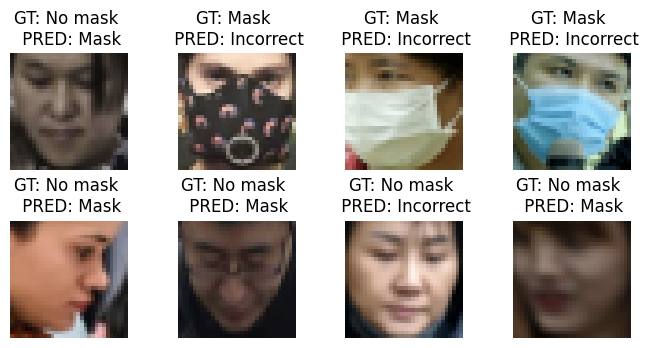

In [90]:
# Create accuracy metric
metric = torchmetrics.Accuracy(task="multiclass", num_classes=3)
for features, labels in dataloader:
    outputs = model(features)
    
    # Calculate accuracy over the batch
    metric.update(outputs, labels.argmax(dim=-1))
    
# Calculate accuracy over the whole epoch
accuracy = metric.compute()
print(f"Accuracy on all data: {accuracy}")

# Reset metric for the next epoch
metric.reset()
plot_errors(model, dataloader)

## 2.6 Experimenting with dropout

### Description

Dropout helps prevent overfitting by randomly setting some output values to zero during training. In this exercise, you'll build a simple neural network with dropout and observe how it behaves in training and evaluation modes.

``torch.nn`` package is preloaded as ``nn``, and ``features`` is already defined for you.

### Instructions

* Add a dropout layer to the model with a 50% probability of zeroing out elements.
* Set the model to training mode and generate predictions using ``features``, storing the output as ``output_train``.
* Set the model to evaluation mode to disable dropout.
* Generate predictions using ``features``, storing the output as ``output_eval``.

In [22]:
features = torch.tensor([[-1.6144,  0.3364, -0.3387,  0.7167, -1.6380,  0.1019, -0.2380, -0.8669]])

In [23]:
model = nn.Sequential(
    nn.Linear(8, 6),
    nn.Linear(6, 4),
    nn.Dropout(p=0.5))

model.train()
output_train = model(features)

# Forward pass in evaluation mode (Dropout disabled)
model.eval()
output_eval = model(features)

# Print results
print("Output in train mode:", output_train)
print("Output in eval mode:", output_eval)

Output in train mode: tensor([[-0.0000,  0.0000, -0.4331, -0.0000]], grad_fn=<MulBackward0>)
Output in eval mode: tensor([[-0.2564,  0.0561, -0.2166, -0.2583]], grad_fn=<AddmmBackward0>)


## 2.7 Quiz: Understanding overfitting

### Description

Overfitting is very common in machine learning, where the trend is for bigger and bigger models. As a machine learning practitioner, you will face overfitting in your career. 

### Instructions

Which three of the following statements about overfitting are True?

### Answers

1. Overfitting happens when the model is performing worse on the validation set than on the training set. [X]
2. Data augmentation can reduce overfitting by artificially increasing the size of the training set. [X]
3. Using a weight decay factor of zero will reduce overfitting.
4. A dropout layer with a probability greater than zero will help reduce overfitting. [X]

## 2.8 Implementing random search

### Description

Hyperparameter search is a computationally costly approach to experiment with different hyperparameter values. However, it can lead to performance improvements. In this exercise, you will implement a random search algorithm.

You will randomly sample 10 values of the learning rate and momentum from the uniform distribution. To do so, you will use the ``np.random.uniform()`` function.

``numpy`` package has already been imported as ``np``, and a ``plot_hyperparameter_search()`` function has been created to visualize your results.

### Instructions

* Randomly sample a learning rate factor between ``2`` and ``4`` so that the learning rate (``lr``) is bounded between 10<sup>-2</sup> and 10<sup>-4</sup> 
* Randomly sample a momentum between 0.85 and 0.99.

In [24]:
def plot_hyperparameter_search(values):
    lrs, momentums = zip(*values)

    plt.figure(figsize=(8, 6))
    plt.scatter(lrs, momentums)
    plt.xscale("log")  # Use log scale for learning rate
    plt.xlabel("Learning Rate")
    plt.ylabel("Momentum")
    # plt.title("Randomly Sampled Learning Rates and Momentum")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Set specific tick marks on the x-axis
    plt.xticks([10**-2, 10**-3, 10**-4], 
               [r'$10^{-2}$', r'$10^{-3}$', r'$10^{-4}$'])

    plt.show()


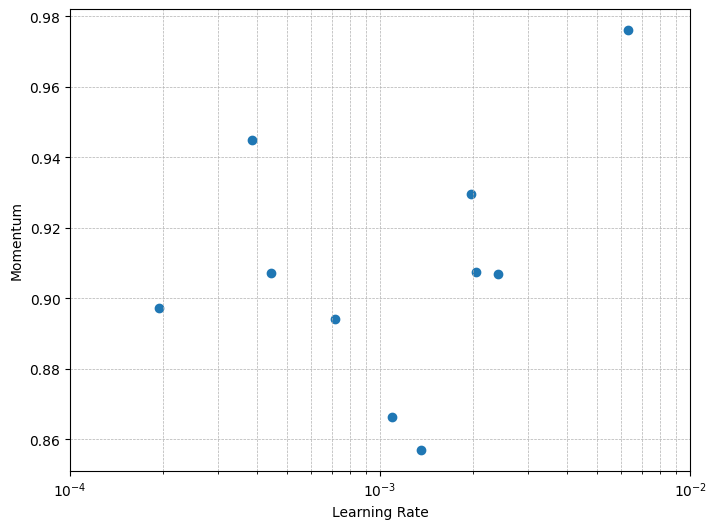

In [25]:
values = []
for idx in range(10):
    # Randomly sample a learning rate factor between 2 and 4
    factor = np.random.uniform(2,4)
    lr = 10 ** -factor
    
    # Randomly select a momentum between 0.85 and 0.99
    momentum = np.random.uniform(0.85, 0.99)
    
    values.append((lr, momentum))
       
plot_hyperparameter_search(values)

Random search helps refine hyperparameters efficiently. Just remember—keeping track of results is key to understanding what works best for your model.